In [1]:
import sys
sys.path.append('..')

In [2]:
from nbhd.data import Base

In [3]:
db = Base()

Initializing database connection...
Database connected!


In [4]:
from xy import xy

In [5]:
from shapely.geometry import Point

In [6]:
pixel = db.intersects('pixels', Point(xy))

In [7]:
tiles = db.intersects('tiles2', pixel.geometry[0])

In [8]:
from shapely.geometry import MultiPolygon

In [9]:
import geopandas as gpd

<AxesSubplot:>

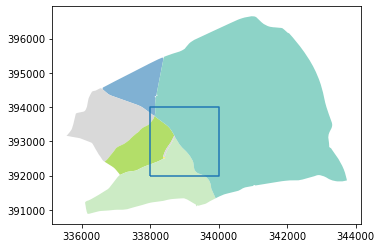

In [10]:
ax = tiles.plot('c', cmap='Set3')
pixel.boundary.plot(ax=ax)

In [11]:
mpgn = MultiPolygon(list(gpd.GeoSeries(tiles.geometry).geometry.values))

In [12]:
from nbhd.geography import get_communities

In [13]:
df, graphs = get_communities(db, mpgn)

Starting to find neighbourhoods in polygon centred at POINT (339792.7393953381 393607.1127502455)
Collected 78931 properties...
... of which 70898 are in buildings
Getting streets...
Snapping nodes...
Finding connected graphs...
Labelling communities.


In [15]:
df.to_csv('communities.csv',index=None)

In [17]:
import networkx as nx

In [23]:
for i, g in enumerate(graphs):
    try:
        nx.write_gml(g, f'graphs/{i}.gml')
    except:
        pass

In [100]:
len(graphs)

137

In [16]:
import matplotlib.pyplot as plt

In [14]:
df0 = df.loc[df.geometry.within(pixel.geometry[0])]

<AxesSubplot:>

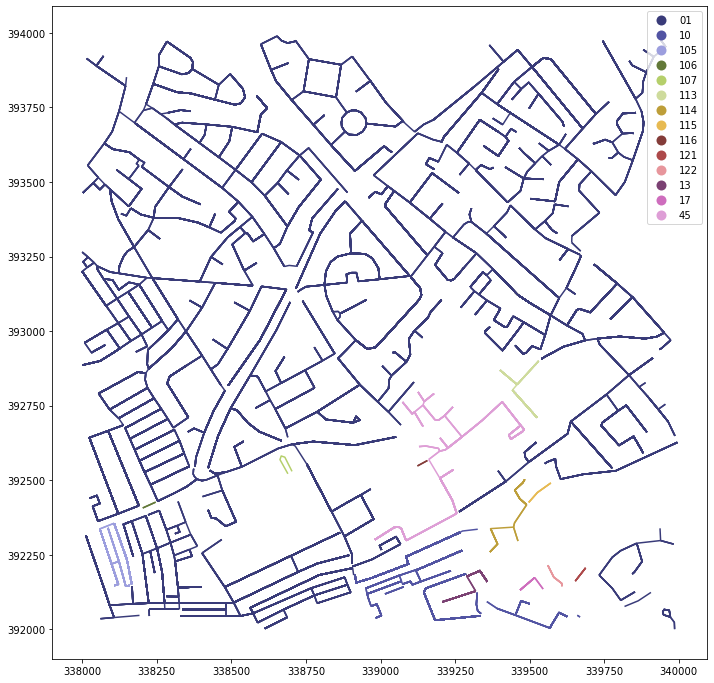

In [21]:
f, ax = plt.subplots(figsize=(12,12))
df0.plot('community', legend=True, ax=ax, cmap='tab20b')

In [45]:
class Community:
    def __init__(self, df, graph_list, label_number):
        
        self.number = label_number
        self.label = str(label_number + 1).zfill(2)
        self.df = df.loc[df.community == self.label]
        self.roadsdf = self.df.loc[
                        ~self.df.roads_id.duplicated()]
        self.buildingsdf = self.df.loc[~self.df.buildings_id.duplicated()]
        self.graph = graph_list[self.number]
        self.stats()
        
    def get_gdfs(self):
        self.gdf = dict()
        self.gdf['properties'] = gpd.GeoDataFrame(self.df, 
                                                  geometry=gpd.GeoSeries.from_wkb(
                                                      self.df.properties_geometry))
        self.gdf['buildings'] = gpd.GeoDataFrame(self.df, 
                                                  geometry=gpd.GeoSeries.from_wkb(
                                                      self.df.buildings_geometry))
        self.gdf['roads'] = gpd.GeoDataFrame(self.roadsdf, 
                                                  geometry=gpd.GeoSeries.from_wkb(
                                                      self.roadsdf.roads_geometry))
    
    def stats(self):
        self.count = dict()
        self.count['properties'] = len(self.df.properties_id.unique())
        self.count['roads'] = len(self.df.roads_id.unique())
        self.count['buildings'] = len(self.df.buildings_id.unique())
        
        self.count[
            'total_street_length'] = self.roadsdf.length.sum()
        self.count['road_stats'] = self.roadsdf.length.describe()
        self.count['norm_road_stats'] = self.roadsdf.street_length_per_uprn.describe()
        
        self.count['total_building_footprint'] = self.buildingsdf.footprint_area.sum()
        self.count['building_stats'] = self.buildingsdf.footprint_area.describe()
        self.count['norm_building_stats'] = self.buildingsdf.footprint_area_per_uprn.describe()
        
        self.count['graph_stats']
    
    def __repr__(self):
        return str(f'Community {label_number}')

In [46]:
communities = list()
for label in df.community.unique():
    if label:
        label_number = int(label) -1
        communities.append(Community(df, graphs, label_number))

In [47]:
communities[0].count

{'properties': 42833,
 'roads': 2543,
 'buildings': 10399,
 'total_street_length': 237695.4775438843,
 'road_stats': count    2543.000000
 mean       93.470498
 std        66.336319
 min         8.470489
 25%        49.281473
 50%        71.700767
 75%       118.073178
 max       645.963612
 dtype: float64}

In [48]:
c = communities[0]

In [49]:
c.buildingsdf.columns

Index(['properties_id', 'properties_geometry', 'roads_id', 'startNode',
       'endNode', 'roads_geometry', 'dist_x', 'geometry', 'length',
       'street_counts', 'street_length_per_uprn', 'residential_street',
       'residential', 'short_street', 'res_or_short', 'community',
       'buildings_id', 'buildings_geometry', 'dist_y', 'building_counts',
       'footprint_area', 'footprint_area_per_uprn', 'residential_building'],
      dtype='object')

In [58]:
c.buildingsdf.footprint_area_per_uprn.describe()

count    10399.000000
mean        63.507487
std         29.244084
min          5.608921
25%         47.560663
50%         55.597350
75%         70.090969
max        249.128000
Name: footprint_area_per_uprn, dtype: float64

In [59]:
c.buildingsdf.footprint_area.describe()

count    10399.000000
mean       230.063005
std        260.816197
min         21.148000
25%        106.477200
50%        151.514400
75%        252.880950
max       9255.059400
Name: footprint_area, dtype: float64

In [65]:
import pandas as pd

In [81]:
prdf2 = pd.DataFrame(nx.edge_betweenness_centrality(c.graph, weight='length'), index=['centrality']).T

In [79]:
c.graph

In [80]:
prdf2.centrality.sort_values(ascending=False).describe()

In [80]:
prdf.centrality.sort_values(ascending=False).describe()

count    2652.000000
mean        0.016854
std         0.041116
min         0.000000
25%         0.000911
50%         0.002247
75%         0.008514
max         0.379906
Name: centrality, dtype: float64

In [53]:
c.df.footprint_area_per_uprn.sum()

2370274.346732528

<AxesSubplot:>

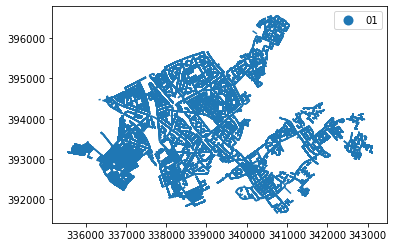

In [79]:
c.gdf['properties'].plot('community', legend=True)

In [41]:
c.df.loc[~c.df.roads_id.duplicated()].length.describe()

count    2543.000000
mean       93.470498
std        66.336319
min         8.470489
25%        49.281473
50%        71.700767
75%       118.073178
max       645.963612
dtype: float64

In [87]:
c.graph.size()

2652

In [88]:
c.graph.order()

2196

In [91]:
len(c.graph.edges())

2652

In [99]:
pd.DataFrame(c.graph.degree, columns=['node','degree']).degree.describe()

count    2196.000000
mean        2.415301
std         0.941875
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         5.000000
Name: degree, dtype: float64

In [95]:
import pandas as pd

In [94]:
len(c.gdf['roads'])

42833

In [58]:
import networkx as nx

<AxesSubplot:>

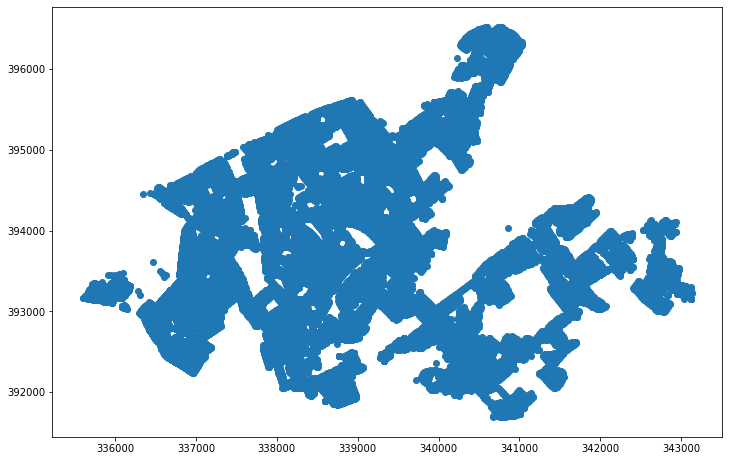

In [66]:
f, ax = plt.subplots(figsize=(12,12))
gpd.GeoDataFrame(c.df, geometry=gpd.GeoSeries.from_wkb(c.df.properties_geometry)).plot(ax=ax)

<module 'geopandas' from '/opt/conda/lib/python3.8/site-packages/geopandas/__init__.py'>

In [69]:
c.count

{'properties': 42833, 'roads': 2543, 'buildings': 10399}